In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
from hipe4ml.analysis_utils import train_test_generator
from hipe4ml import plot_utils
from enum import Enum
import gc, os
import plotly
import itertools

In [2]:
#PLAINTREE FILES NAMES
directory='/Users/julnow/gsi/mgr/'
# filename = directory + 'trees/PlainTree200k_trdrich_12agev.root'
fileName = directory + 'trees/PlainTree2M_DCM_trdrich_12agev.root'
fileNameTest = directory + 'trees/PlainTree1M_URQMD_trdrich_12agev.root'
directory= directory + 'jupyter/'

In [3]:
#preselection and quality cuts
mass2Cut = """ -1. < Complex_mass2 < 2."""
pTCut = """0 < Complex_pT < 2."""
antiParticles : bool = False
if antiParticles == False:
    qCut = """ Complex_q > 0 """
elif antiParticles == True:
    qCut = """ Complex_q < 0 """
pCut = " {lower} < Complex_p < {upper} ".format(lower = 0, upper = 12)
etaCut = """ 0 < Complex_eta < 6 """

In [4]:
# %%time
#data import with preselections
def loadFile(fileName: str) -> TreeHandler:
    return (TreeHandler(fileName,'plain_tree')
        .get_subset(mass2Cut)
        .get_subset(pTCut)
        .get_subset(qCut)
        .get_subset(pCut)
        .get_subset(etaCut))

particles = loadFile(fileName)

In [5]:
particles.get_data_frame()

Complex_axis_a_rich  Complex_axis_b_rich  Complex_chi2_ov_ndf_rich  \
1                    5.839708             5.313001                  0.520030   
2                    4.722127             4.181828                  0.456715   
3                    5.038812             4.847986                  0.624823   
6                    4.239638             4.029764                  0.398865   
7                    5.390869             5.038420                  0.541778   
...                       ...                  ...                       ...   
13422096             5.360107             5.175754                  0.341745   
13422097             4.140916             4.054016                  0.336611   
13422099             4.551208             4.523862                  0.612748   
13422100             5.264062             5.200163                  0.467887   
13422102             4.917819             4.520442                  0.314478   

          Complex_chi2_vtx  Complex_eta  Complex_mass  Complex_mass2  \
1                 3.254713     1.615815      0.139570       0.013776   
2                 6.383036     2.477988      0.139570       0.009510   
3                 0.998935     1.566007      0.938272       0.841820   
6                 1.046744     3.441660      0.139570      -0.139324   
7                 0.983985     3.756489      0.139570       0.022315   
...                    ...          ...           ...            ...   
13422096          8.319921     2.206841      0.000511      -0.001305   
13422097          0.963536     2.898335      0.139570      -0.494093   
13422099          1.295547     2.680335      0.139570       0.026524   
13422100         24.926378     3.262257      0.000511      -0.006512   
13422102          0.928862     2.069009      0.938272       0.853429   

          Complex_p  Complex_pT  Complex_phi  ...  Complex_rapidity  \
1          1.040541    0.397858     1.967648  ...          1.562429   
2          0.877198    0.146186     1.035680  ...          2.160347   
3          2.510879    1.005081    -2.103101  ...          1.287279   
6          7.295185    0.466586    -1.671218  ...          3.398896   
7          0.888626    0.041505    -1.281722  ...          2.507459   
...             ...         ...          ...  ...               ...   
13422096   0.778512    0.169297    -0.202477  ...          2.206836   
13422097   7.576376    0.832612    -2.154835  ...          2.884563   
13422099   1.601087    0.218452     0.683216  ...          2.511081   
13422100   1.579304    0.120803    -1.967364  ...          3.262257   
13422102   3.725252    0.926302     0.181391  ...          1.731714   

          Complex_trd_proba_e  Complex_trd_proba_k  Complex_trd_proba_p  \
1                    0.003401             0.426412             0.173623   
2                    0.049470             0.324028             0.285724   
3                    0.000637             0.374106             0.360184   
6                    0.006553             0.340533             0.302488   
7                    0.000342             0.525351             0.069788   
...                       ...                  ...                  ...   
13422096             0.104533             0.223607             0.409003   
13422097             0.007933             0.264198             0.199355   
13422099             0.001500             0.440206             0.229894   
13422100             0.358945             0.187007             0.255241   
13422102             0.000801             0.376102             0.441774   

          Complex_trd_proba_pi  Complex_id  Complex_n_hits_rich  \
1                     0.396563         1.0                 29.0   
2                     0.340778         2.0                 27.0   
3                     0.265073         3.0                 18.0   
6                     0.350426         6.0                 22.0   
7                     0.404519         7.0                 26.0   
...                        .

In [6]:
class Pid(Enum):
    POSITRON = -11.0
    ELECTRON = 11.0
    PROTON = 2212.0
    ANTI_PROTON = -2212.0 
    NEG_MUON = -13.0
    POS_MUON = 13.0
    NEG_PION = -211.0
    POS_PION = 211.0
    NEG_KAON = -321.0
    POS_KAON = 321.0
    @classmethod
    def is_known_particle(cls, value):
        return value in cls._value2member_map_ 

def getParticlesType(th: TreeHandler, pid: float, nsigma: float = 0.) -> TreeHandler:
    particles = (th.get_subset("Complex_pid == {}"
        .format(pid)))
    #getting selected nsigma region in the mass2
    if nsigma > 0 :
        df   = particles.get_data_frame()["Complex_mass2"]
        mean = df.mean()
        std  = df.std()
        particles = (particles.get_subset(("{lower} < Complex_mass2 < {upper}")
                     .format(lower = str(mean-nsigma*std), upper = str(mean+nsigma*std))))
    return particles

def sim_tof(df, pid: int):

    qp = df['Complex_q']*df['Complex_p']
    var_xaxis = qp
    mass2 = df['Complex_mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c^2)^2$'
    ranges = [[-13, 13],[-1, 2]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200, norm=mpl.colors.LogNorm(), range=ranges)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for all simulated particle ID = ' + str(pid)
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    plt.show()

In [7]:
if antiParticles == False:
    protons = getParticlesType(particles, Pid.PROTON.value, 3)
    kaons = getParticlesType(particles, Pid.POS_KAON.value, 3)
    pions = getParticlesType(particles, [Pid.POS_PION.value, Pid.POS_MUON.value, Pid.POSITRON.value], 3)
    # muons = getParticlesType(particles, Pid.POS_MUON.value)
    # electrons = getParticlesType(particles, Pid.POSITRON.value)
elif antiParticles == True:
    protons = getParticlesType(particles, Pid.ANTI_PROTON.value, 3)
    kaons = getParticlesType(particles, Pid.NEG_KAON.value, 3)
    pions = getParticlesType(particles, [Pid.NEG_PION.value, Pid.NEG_MUON.value, Pid.ELECTRON.value], 3)
    # muons = getParticlesType(particles, Pid.NEG_MUON.value)
    # electrons = getParticlesType(particles, Pid.ELECTRON.value)  
    
del particles
gc.collect()

2305

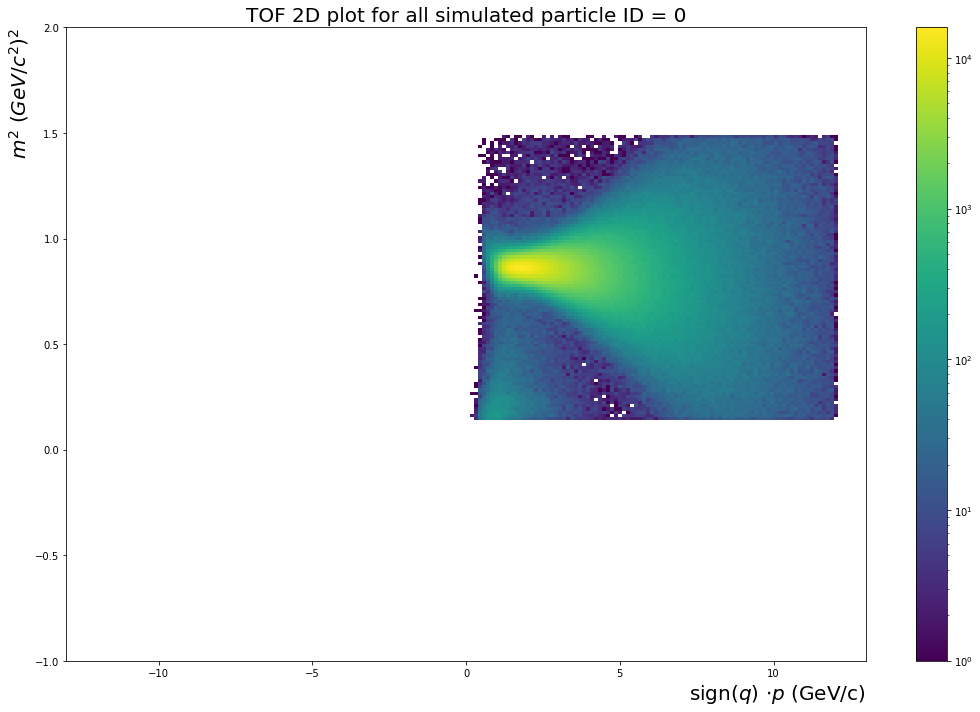

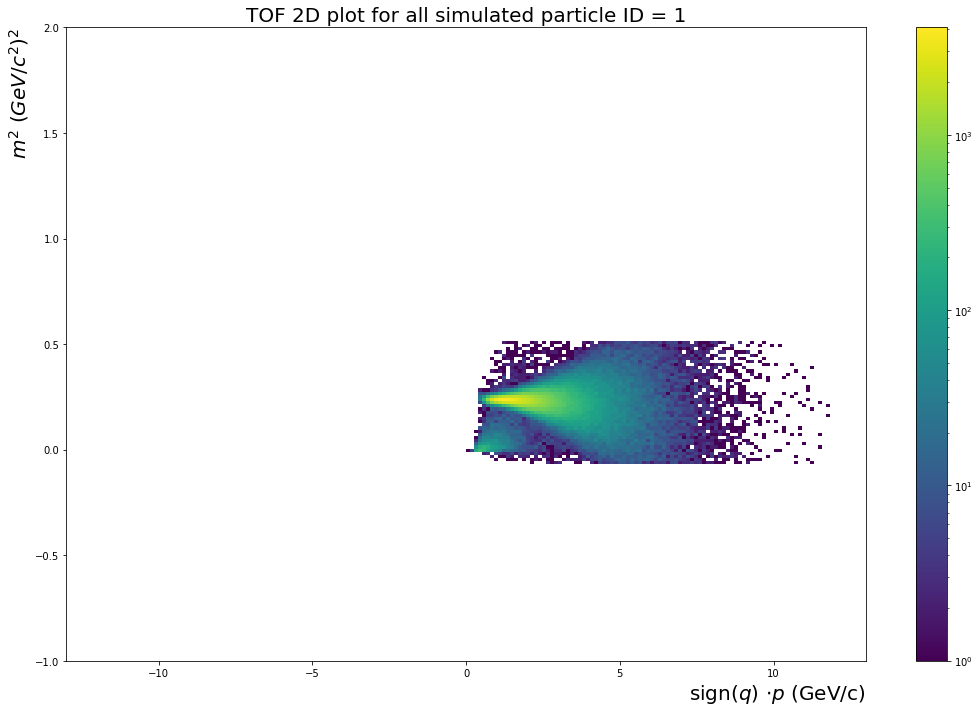

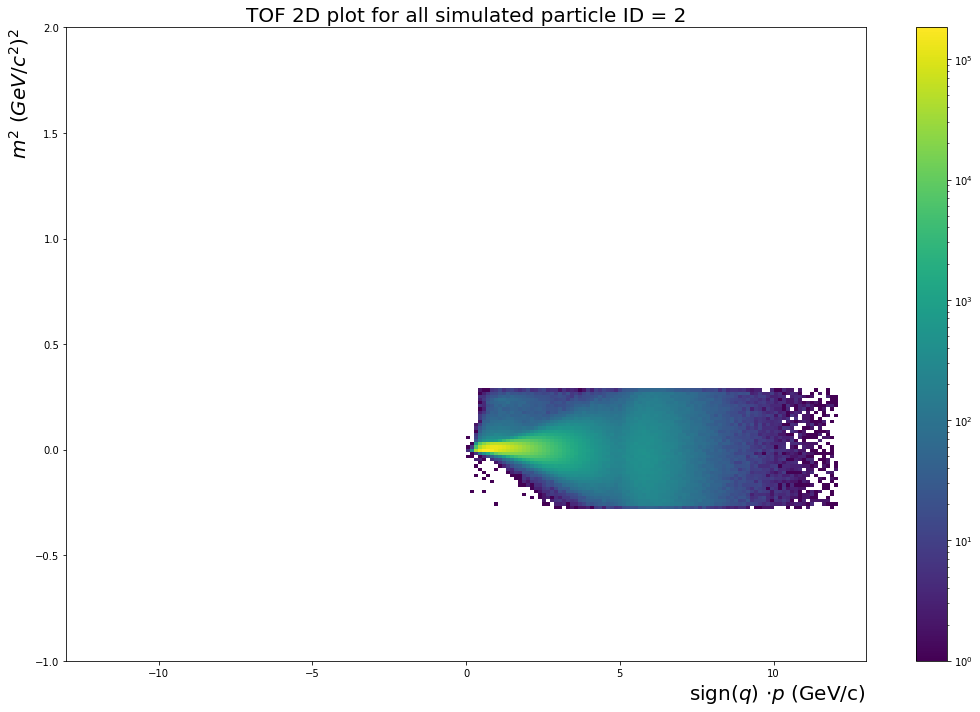

In [8]:
sim_tof(protons.get_data_frame(), 0)
sim_tof(kaons.get_data_frame(), 1)
sim_tof(pions.get_data_frame(), 2)

In [9]:
pions.get_data_frame().head(10)

Complex_axis_a_rich  Complex_axis_b_rich  Complex_chi2_ov_ndf_rich  \
1              5.839708             5.313001                  0.520030   
2              4.722127             4.181828                  0.456715   
6              4.239638             4.029764                  0.398865   
7              5.390869             5.038420                  0.541778   
10             5.481655             5.204248                  0.389541   
12             5.282866             4.732232                  0.292067   
14             5.701984             5.217088                  1.302346   
18             5.314752             5.225073                  0.382319   
19             5.783454             4.598697                  1.305916   
26             5.635751             5.426417                  0.471135   

    Complex_chi2_vtx  Complex_eta  Complex_mass  Complex_mass2  Complex_p  \
1           3.254713     1.615815      0.139570       0.013776   1.040541   
2           6.383036     2.477988      0.139570       0.009510   0.877198   
6           1.046744     3.441660      0.139570      -0.139324   7.295185   
7           0.983985     3.756489      0.139570       0.022315   0.888626   
10         16.352009     2.234060      0.000511      -0.000921   0.460188   
12          2.799417     1.127367      0.000511      -0.004686   0.981654   
14          1.042173     1.710407      0.139570       0.000192   1.535469   
18          0.079938     1.948034      0.139570       0.049822   2.441890   
19          0.372232     3.244246      0.139570       0.093843   4.056406   
26          0.701677     3.479935      0.139570       0.022383   1.635057   

    Complex_pT  Complex_phi  ...  Complex_rapidity  Complex_trd_proba_e  \
1     0.397858     1.967648  ...          1.562429             0.003401   
2     0.146186     1.035680  ...          2.160347             0.049470   
6     0.466586    -1.671218  ...          3.398896             0.006553   
7     0.041505    -1.281722  ...          2.507459             0.000342   
10    0.097448    -2.465459  ...          2.234046            -1.500000   
12    0.575513    -2.893483  ...          1.127367             0.096185   
14    0.537629    -3.062980  ...          1.679923             0.001239   
18    0.682336    -0.169414  ...          1.928373             0.007393   
19    0.315901     1.801286  ...          3.155386             0.000773   
26    0.100655    -1.021812  ...          2.945500             0.017450   

    Complex_trd_proba_k  Complex_trd_proba_p  Complex_trd_proba_pi  \
1              0.426412             0.173623              0.396563   
2              0.324028             0.285724              0.340778   
6              0.340533             0.302488              0.350426   
7              0.525351             0.069788              0.404519   
10            -1.500000            -1.500000             -1.500000   
12             0.175298             0.497897              0.230621   
14             0.457461             0.212057              0.329243   
18             0.323029             0.328961              0.340617   
19             0.371574             0.453110              0.174543   
26             0.311063             0.329330              0.342157   

    Complex_id  Complex_n_hits_rich  Complex_nhits_trd  Complex_pid  Complex_q  
1          1.0                 29.0                4.0        211.0        1.0  
2          2.0                 27.0                2.0        211.0        1.0  
6          6.0                 22.0                3.0        211.0        1.0  
7          7.0                 26.0                4.0        211.0        1.0  
10        10.0                 35.0                4.0        -11.0        1.0  
12        12.0                 27.0                4.0        -11.0        1.0  
14         1.0                 22.0                4.0        211.0        1.0  
18         5.0                 20.0                3.0        211.0        1.0  
19         6.0 

In [10]:
train_test_data = train_test_generator([protons, kaons, pions], [0,1,2], 
    test_size=0.1, random_state=42)

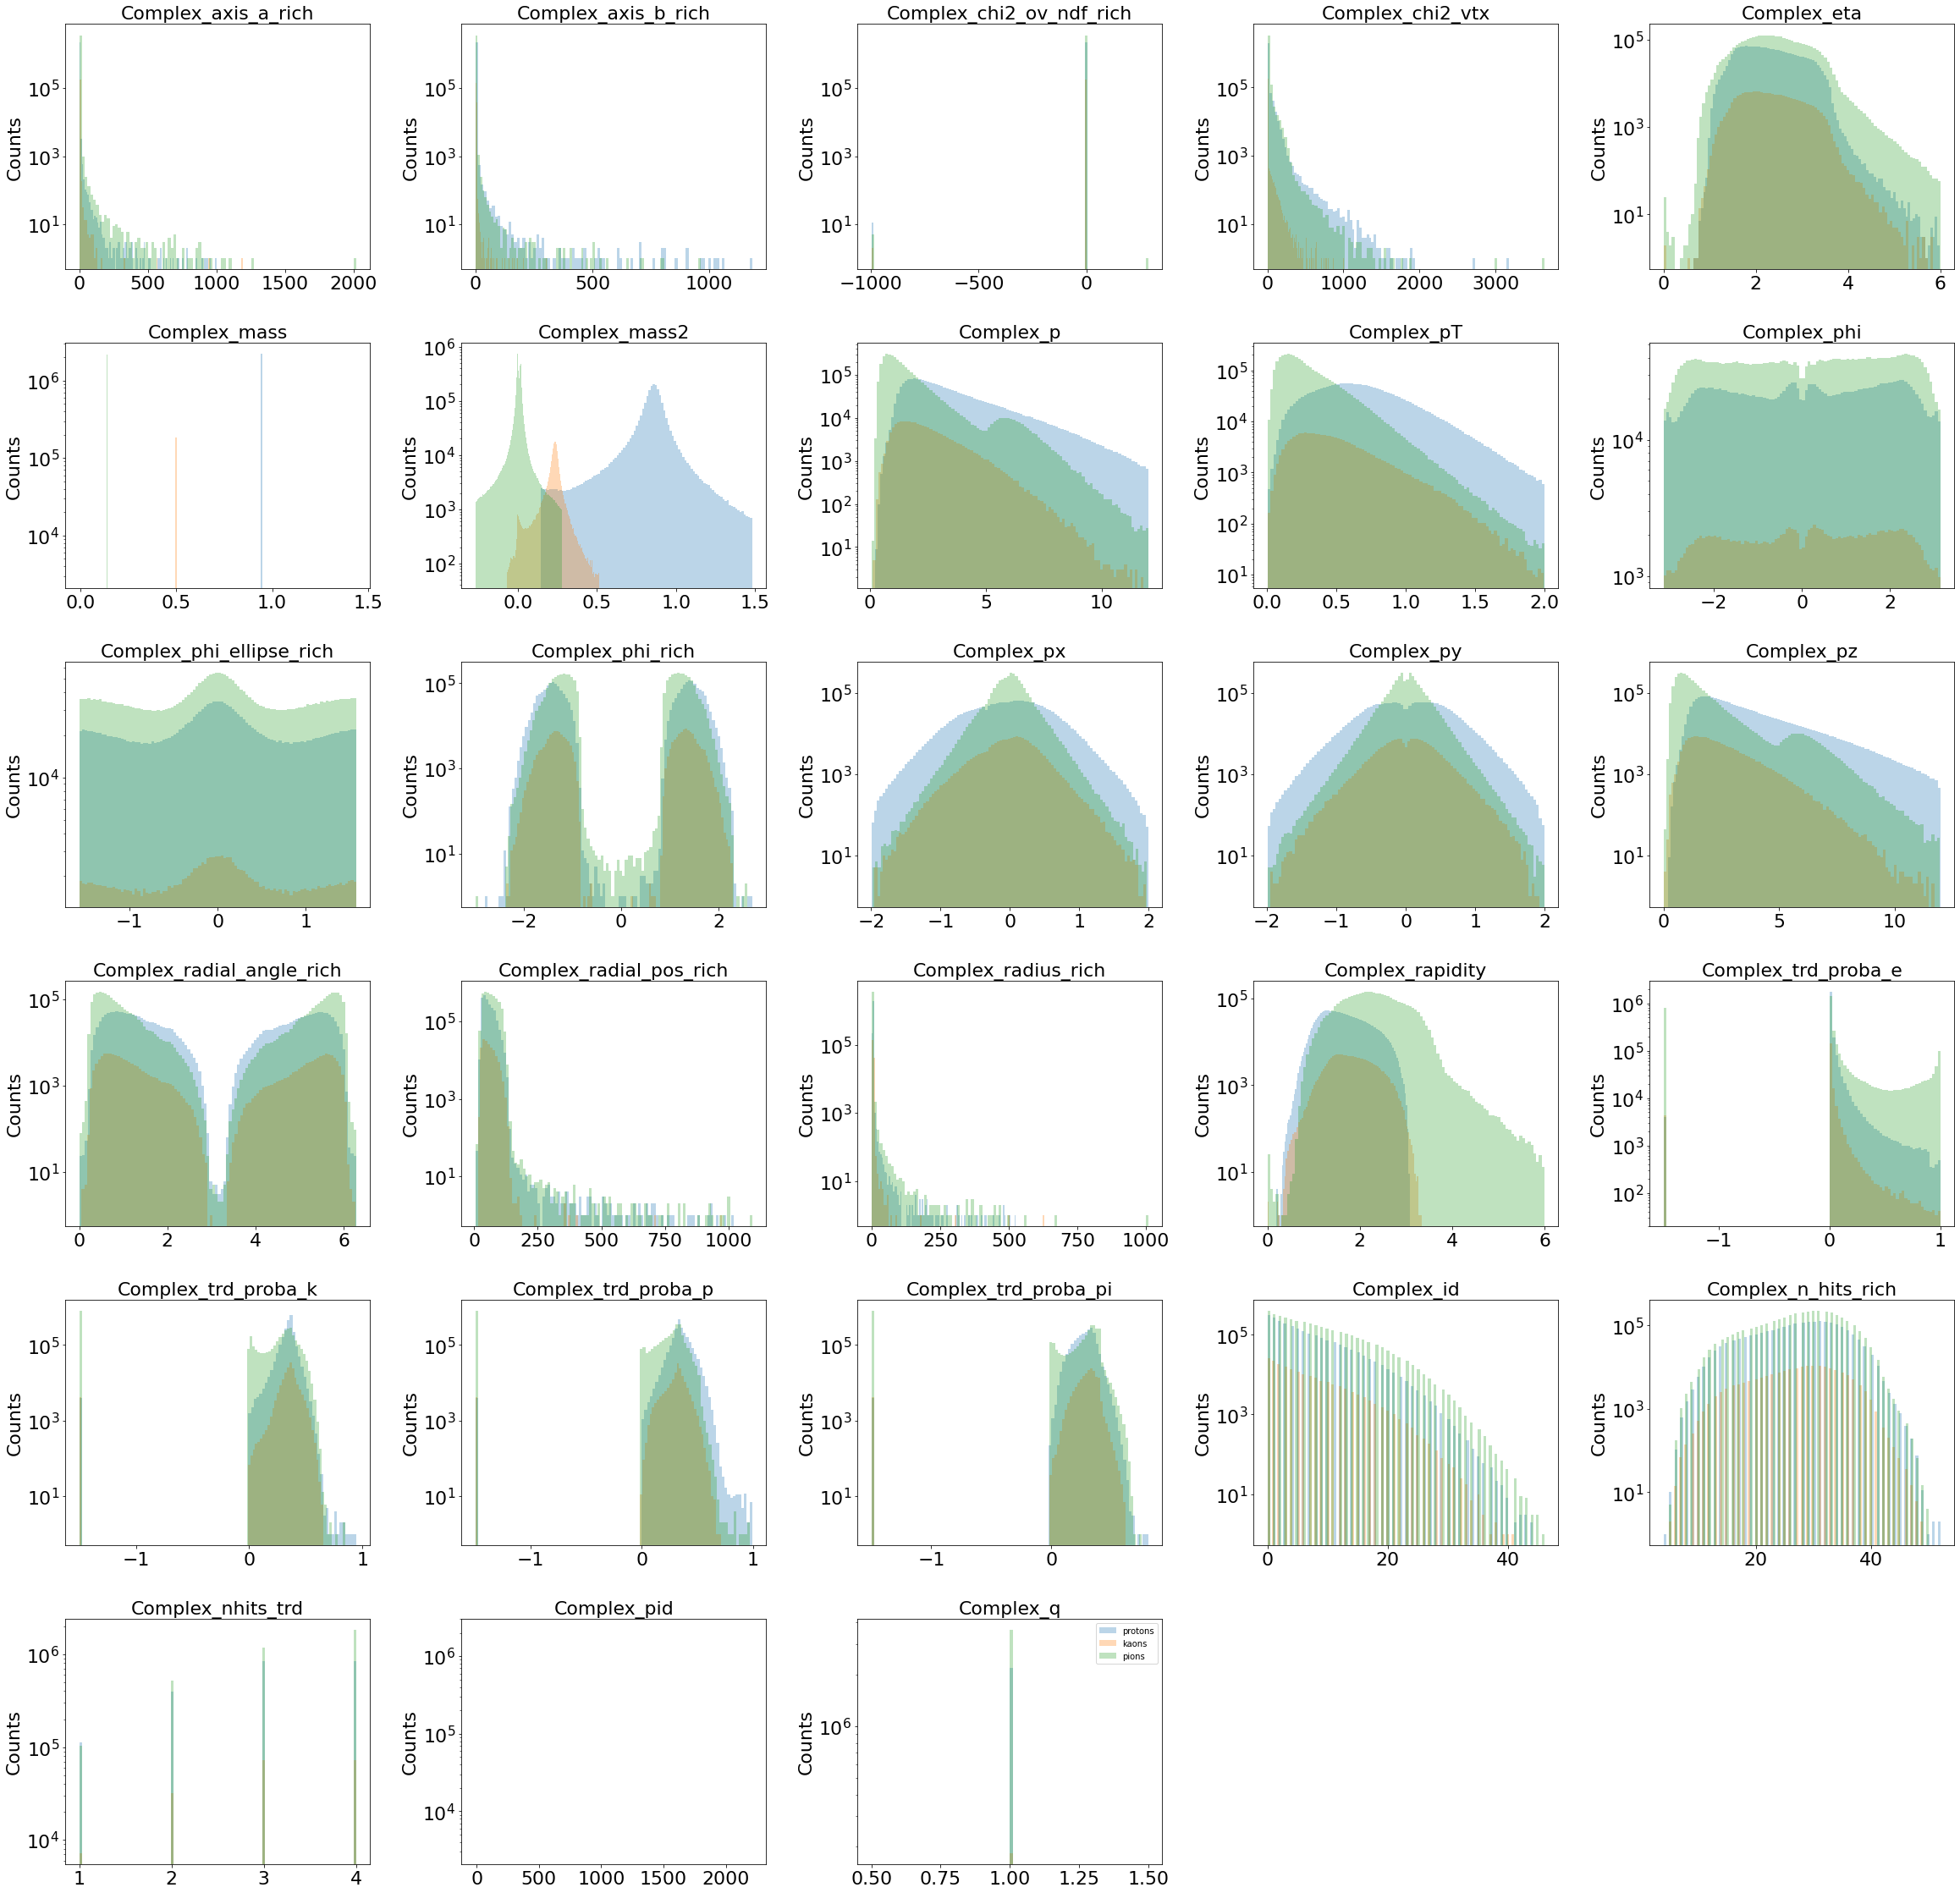

In [11]:
import matplotlib

params = {'axes.titlesize':'22','axes.labelsize':'22',
          'xtick.labelsize':'22',
          'ytick.labelsize':'22'}
matplotlib.rcParams.update(params)

vars_to_draw =  protons.get_var_names()

leg_labels = ['protons', 'kaons', 'pions']

plot_utils.plot_distr([protons, kaons, pions], vars_to_draw, bins=100, labels=leg_labels, log=True, figsize=(40, 40), alpha=0.3, grid=False)
plt.show()

<Figure size 432x288 with 0 Axes>

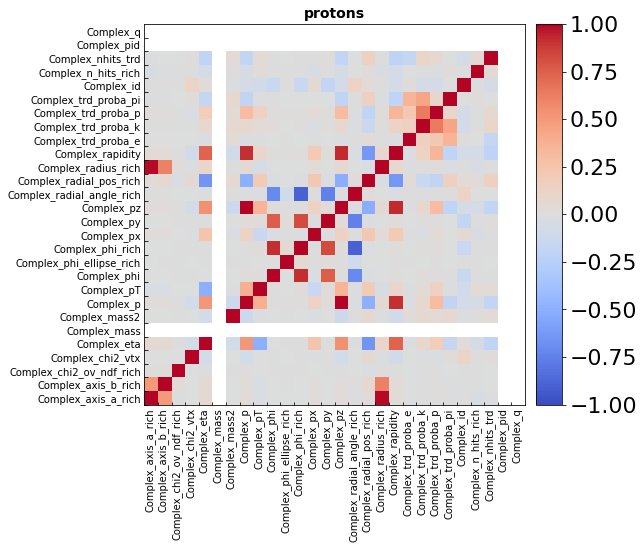

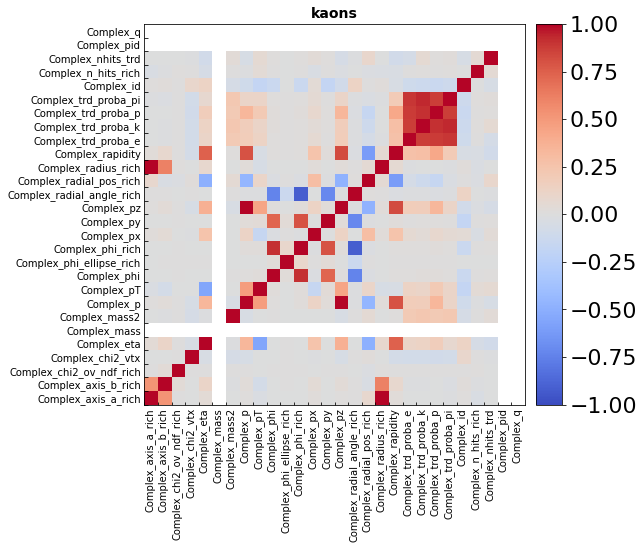

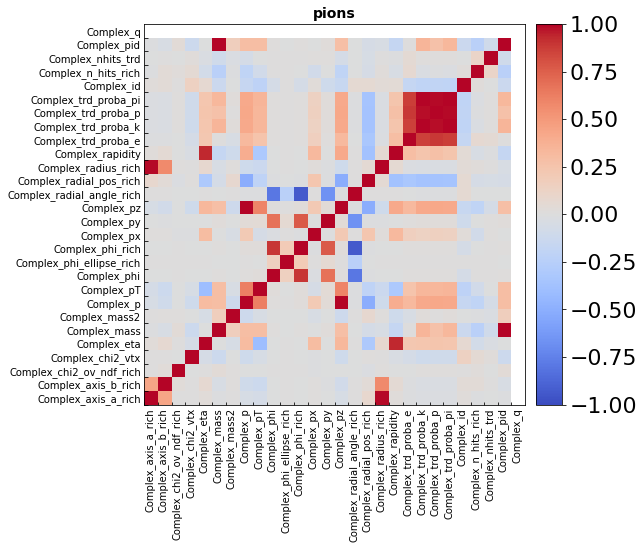

In [12]:
plt.subplots_adjust(left=0.06, bottom=0.06, right=0.99, top=0.96, hspace=0.55, wspace=0.55)
plot_utils.plot_corr([protons, kaons, pions], vars_to_draw, leg_labels)

plt.show()

In [13]:
del protons, kaons, pions
gc.collect()
features_for_train = ['Complex_mass2', 'Complex_p', 'Complex_pT', 'Complex_eta']

In [14]:
model_clf = xgb.XGBClassifier()
model_hdl = ModelHandler(model_clf, features_for_train)

In [13]:
hyper_pars_ranges = {"n_estimators": (400, 1000), "max_depth": (2, 6), "learning_rate": (0.01, 0.1)}
study = model_hdl.optimize_params_optuna(train_test_data, hyper_pars_ranges, cross_val_scoring="roc_auc_ovo", timeout=120,
                                 n_jobs=2, n_trials=2, direction="maximize")

[I 2023-03-07 16:39:10,642] A new study created in memory with name: no-name-4d49444f-0013-4786-a69b-05aaf474760c
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-03-07 18:06:28,450] Trial 1 finished with value: 0.989878324138053 and parameters: {'n_estimators': 596, 'max_depth': 5, 'learning_rate': 0.07161792803939408}. Best is trial 1 with value: 0.989878324138053.
[I 2023-03-07 18:17:57,720] Trial 0 finished with value: 0.9898636421961557 and parameters: {'n_estimators': 682, 'max_depth': 6, 'learning_rate': 0.033270903946551564}. Best is trial 1 with value: 0.989878324138053.


Number of finished trials: 2
Best trial:
Value: 0.989878324138053
Params: 
    n_estimators: 596
    max_depth: 5
    learning_rate: 0.07161792803939408


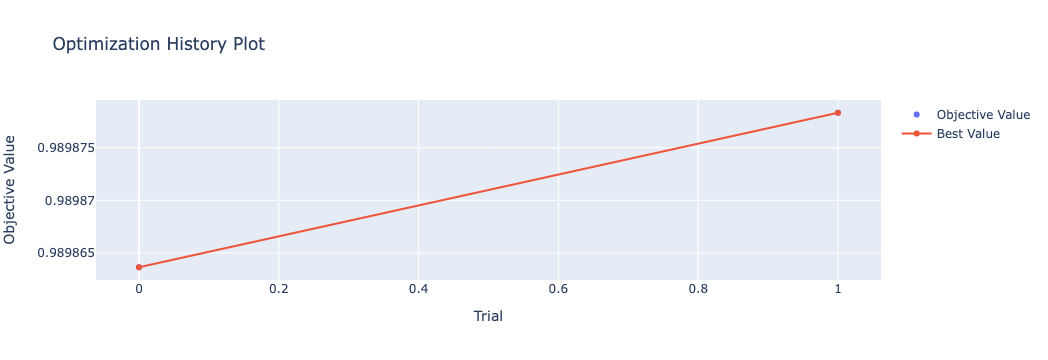

In [14]:
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
plot_optimization_history(study)

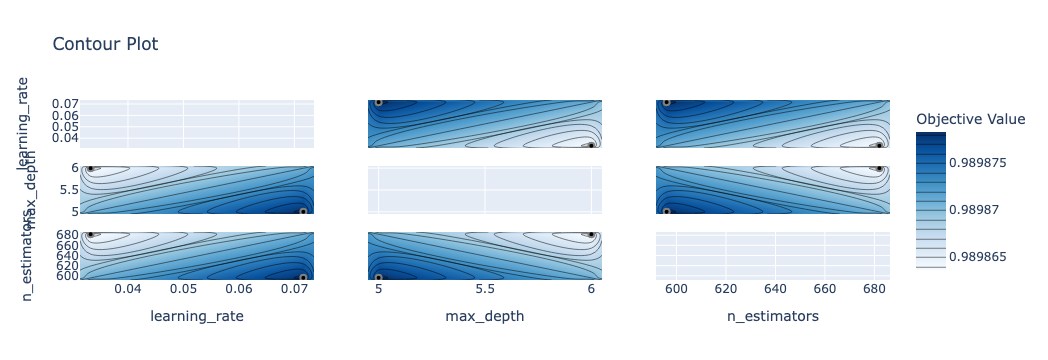

In [15]:
plot_contour(study)

In [15]:
model_hdl.train_test_model(train_test_data, multi_class_opt="ovo")

Training xgboost model for classification
Number of detected classes: 3
Training the model: ...
Training the model: Done!
Testing the model: ...
ROC_AUC_score: 0.997005
Testing the model: Done!


In [16]:
y_pred_train = model_hdl.predict(train_test_data[0], False)
y_pred_test = model_hdl.predict(train_test_data[2], False)

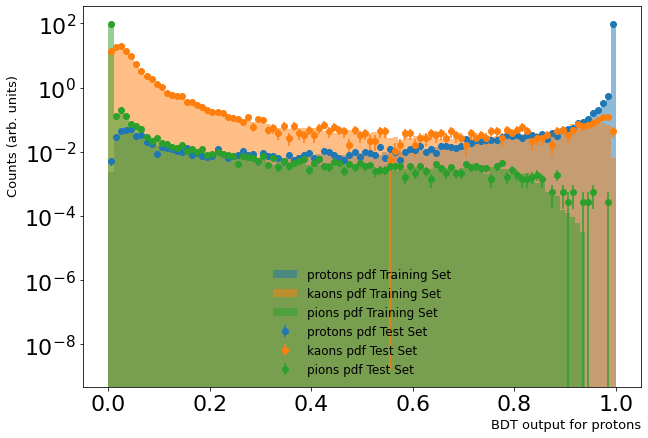

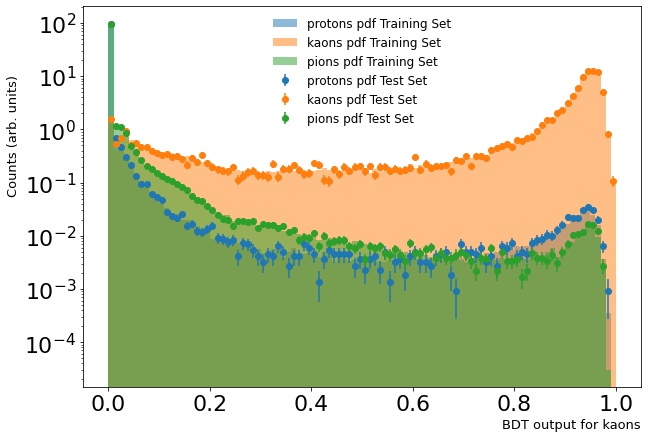

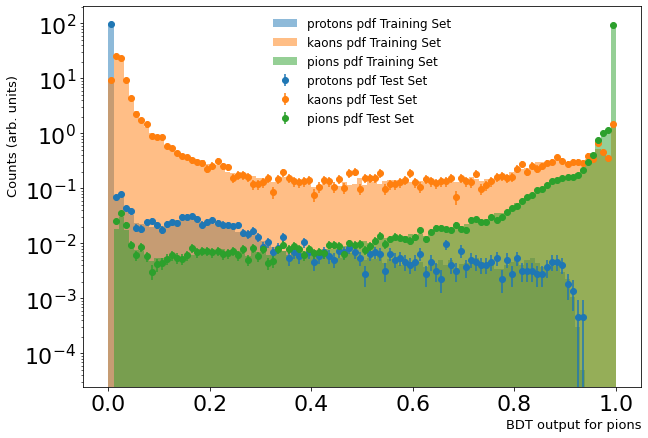

In [17]:
plt.rcParams["figure.figsize"] = (10, 7)

ml_out_fig = plot_utils.plot_output_train_test(model_hdl, train_test_data, 100, 
                                               False, leg_labels, True, density=True)

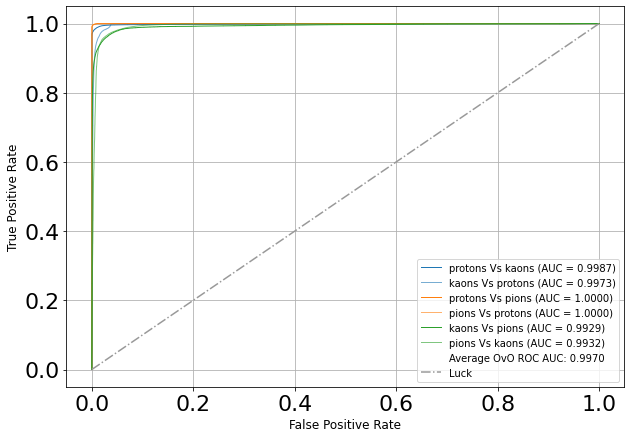

In [18]:
roc_train_test_fig = plot_utils.plot_roc(train_test_data[3], y_pred_test, None, leg_labels, multi_class_opt="ovo")

In [19]:
# #load old model
# model_hdl = ModelHandler()
# model_hdl.load_model_handler("testmodel1")

In [20]:
testParticles = loadFile(fileNameTest)
testParticles.apply_model_handler(model_hdl, False)

In [21]:
testParticles.get_data_frame().head(10)

Complex_axis_a_rich  Complex_axis_b_rich  Complex_chi2_ov_ndf_rich  \
1              5.662631             5.421045                  0.360114   
2              5.243275             4.177869                  0.335153   
4              4.903638             4.571353                  0.645824   
5              6.286244             4.827817                  0.352518   
6              5.433741             5.149516                  0.393934   
8              4.725913             4.143161                  0.453223   
13             4.505507             4.260038                  0.577136   
14             5.636052             5.085966                  0.416395   
15             4.489727             4.472984                  0.201830   
16             5.689525             5.468283                  0.314057   

    Complex_chi2_vtx  Complex_eta  Complex_mass  Complex_mass2  Complex_p  \
1           0.913177     1.962085      0.938272       0.842410   3.123042   
2           0.898197     1.987503      0.139570       0.022546   1.305182   
4           1.915188     2.019851      0.938272       0.896047   3.375997   
5           1.376054     2.822898      0.493677       0.242548   0.931229   
6           1.795004     4.000828      0.139570       0.022527   1.286823   
8          19.221722     1.668156      0.105658       0.017113   1.065189   
13          5.239684     1.552670      0.000511       0.000030   0.822712   
14          0.714092     3.786115      0.000511       0.002357   1.803974   
15          0.289736     2.522050      0.139570       0.263474   8.877517   
16          0.650250     1.113330      0.139570       0.023362   1.245178   

    Complex_pT  Complex_phi  ...  Complex_trd_proba_p  Complex_trd_proba_pi  \
1     0.860970    -0.086505  ...             0.356348              0.282730   
2     0.351123    -0.398274  ...             0.213216              0.378678   
4     0.880326    -2.850327  ...             0.343331              0.290947   
5     0.110303    -2.668816  ...             0.287283              0.339278   
6     0.047084    -0.496723  ...             0.130688              0.403290   
8     0.387978    -1.480915  ...             0.213611              0.392055   
13    0.333369     1.920200  ...             0.328646              0.134518   
14    0.081799    -0.624524  ...             0.014337              0.010771   
15    1.416508    -0.122381  ...             0.413462              0.219556   
16    0.738333    -2.871337  ...             0.064146              0.389257   

    Complex_id  Complex_n_hits_rich  Complex_nhits_trd  Complex_pid  \
1          1.0                 18.0                3.0       2212.0   
2          2.0                 22.0                3.0        211.0   
4          4.0                 27.0                3.0       2212.0   
5          5.0                 15.0                2.0        321.0   
6          6.0                 17.0                4.0        211.0   
8          8.0                 27.0                4.0        -13.0   
13         4.0                 40.0                4.0        -11.0   
14         5.0                 29.0                4.0         11.0   
15         0.0                 20.0                2.0        211.0   
16         1.0                 16.0                3.0        211.0   

    Complex_q  model_output_0  model_output_1  model_output_2  
1         1.0        0.999998        0.000001    8.066111e-07  
2         1.0        0.000003        0.000495    9.995015e-01  
4         1.0        0.999997        0.000002    1.685097e-06  
5         1.0        0.054275        0.927971    1.775448e-02  
6         1.0        0.000001        0.000564    9.994350e-01  
8         1.0        0.000005        0.000330    9.996657e-01  
13        1.0        0.000003        0.000429    9.995678e-01  
14        1.0        0.000002        0.000269    9.997297e-01  
15        1.0        0.813724        0.022683    1.635937e-01  
16        1.0        0.000001        0.000106    

In [22]:
def xgb_preds(df, probaProton, probaKaon, probaPion):
    #getting max field
    df['xgb_preds']=df[["model_output_0", "model_output_1", "model_output_2"]].idxmax(axis = 1)
    #setting to bckgr if smaller than probability threshold
    proton = (df['xgb_preds'] == 0) & (df["model_output_0"] > probaProton )
    pion   = (df['xgb_preds'] == 1) & (df["model_output_1"] > probaKaon )
    kaon   = (df['xgb_preds'] == 2) & (df["model_output_2"] > probaPion )
    df.loc[( proton | pion | kaon ), 'xgb_preds'] = 3
    df['xgb_preds'] = df['xgb_preds'].map(lambda x: x.lstrip('model_output_')).astype(float)
    return df

from collections import defaultdict
def remap_names(df):
    if antiParticles == False:
        return df.Complex_pid.map(defaultdict(lambda: 3., {Pid.PROTON.value : 0., Pid.POS_KAON.value : 1.,  Pid.POS_PION.value : 2, Pid.POSITRON.value : 2., Pid.POS_MUON.value : 2.}),na_action='ignore').astype(float)
    elif antiParticles == True:
        return df.Complex_pid.map(defaultdict(lambda: 3., {Pid.ANTI_PROTON.value : 0., Pid.NEG_KAON.value : 1.,  Pid.NEG_PION.value : 2., Pid.ELECTRON.value : 2., Pid.NEG_MUON.value : 2.}),na_action='ignore').astype(float)


In [23]:
testParticles = xgb_preds(testParticles.get_data_frame(), .9, .95, .9)
testParticles["Complex_pid"] = remap_names(testParticles)

In [24]:
testParticles.head(10)

Complex_axis_a_rich  Complex_axis_b_rich  Complex_chi2_ov_ndf_rich  \
1              5.662631             5.421045                  0.360114   
2              5.243275             4.177869                  0.335153   
4              4.903638             4.571353                  0.645824   
5              6.286244             4.827817                  0.352518   
6              5.433741             5.149516                  0.393934   
8              4.725913             4.143161                  0.453223   
13             4.505507             4.260038                  0.577136   
14             5.636052             5.085966                  0.416395   
15             4.489727             4.472984                  0.201830   
16             5.689525             5.468283                  0.314057   

    Complex_chi2_vtx  Complex_eta  Complex_mass  Complex_mass2  Complex_p  \
1           0.913177     1.962085      0.938272       0.842410   3.123042   
2           0.898197     1.987503      0.139570       0.022546   1.305182   
4           1.915188     2.019851      0.938272       0.896047   3.375997   
5           1.376054     2.822898      0.493677       0.242548   0.931229   
6           1.795004     4.000828      0.139570       0.022527   1.286823   
8          19.221722     1.668156      0.105658       0.017113   1.065189   
13          5.239684     1.552670      0.000511       0.000030   0.822712   
14          0.714092     3.786115      0.000511       0.002357   1.803974   
15          0.289736     2.522050      0.139570       0.263474   8.877517   
16          0.650250     1.113330      0.139570       0.023362   1.245178   

    Complex_pT  Complex_phi  ...  Complex_trd_proba_pi  Complex_id  \
1     0.860970    -0.086505  ...              0.282730         1.0   
2     0.351123    -0.398274  ...              0.378678         2.0   
4     0.880326    -2.850327  ...              0.290947         4.0   
5     0.110303    -2.668816  ...              0.339278         5.0   
6     0.047084    -0.496723  ...              0.403290         6.0   
8     0.387978    -1.480915  ...              0.392055         8.0   
13    0.333369     1.920200  ...              0.134518         4.0   
14    0.081799    -0.624524  ...              0.010771         5.0   
15    1.416508    -0.122381  ...              0.219556         0.0   
16    0.738333    -2.871337  ...              0.389257         1.0   

    Complex_n_hits_rich  Complex_nhits_trd  Complex_pid  Complex_q  \
1                  18.0                3.0          0.0        1.0   
2                  22.0                3.0          2.0        1.0   
4                  27.0                3.0          0.0        1.0   
5                  15.0                2.0          1.0        1.0   
6                  17.0                4.0          2.0        1.0   
8                  27.0                4.0          3.0        1.0   
13                 40.0                4.0          2.0        1.0   
14                 29.0                4.0          3.0        1.0   
15                 20.0                2.0          2.0        1.0   
16                 16.0                3.0          2.0        1.0   

    model_output_0  model_output_1  model_output_2  xgb_preds  
1         0.999998        0.000001    8.066111e-07        0.0  
2         0.000003        0.000495    9.995015e-01        2.0  
4         0.999997        0.000002    1.685097e-06        0.0  
5         0.054275        0.927971    1.775448e-02        1.0  
6         0.000001        0.000564    9.994350e-01        2.0  
8         0.000005        0.000330    9.996657e-01        2.0  
13        0.000003        0.000429    9.995678e-01        2.0  
14        0.000002        0.000269    9.997297e-01        2.0  
15        0.813724        0.022683    1.635937e-01        0.0  
16        0.000001        0.000106    9.998924e-01        2.0  

[10 rows x 32 columns]

In [25]:
def sigma(df:pd.DataFrame, pid, nsigma=1, info=False):
    mean = df[df['Complex_pid']==pid]['Complex_mass2'].mean()
    std = df[df['Complex_pid']==pid]['Complex_mass2'].std()
    out_sigma = (df['Complex_pid']==pid) & ((df['Complex_mass2'] < (mean-nsigma*std)) | (df['Complex_mass2'] > (mean+nsigma*std)))
    df1 = df[~ out_sigma]
    if info:
        df_len = len(df)
        df1_len = len(df1)
        print('we get rid of ' + str ( round( ( df_len - df1_len) / df_len *100, 2)) + ' % of pid = ' 
              + str(pid) + ' particle entries')
    return df1

In [26]:
testParticles = sigma(testParticles, 0, 3, True)
testParticles = sigma(testParticles, 1, 3, True)
testParticles = sigma(testParticles, 2, 3, True)

we get rid of 1.35 % of pid = 0 particle entries
we get rid of 0.06 % of pid = 1 particle entries
we get rid of 1.5 % of pid = 2 particle entries


In [27]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)

Confusion matrix, without normalization
[[1027283    3318    3906       0]
 [   3145   66975   12839       0]
 [  19475    6204 1527023       0]
 [  87549    9453  326200       0]]


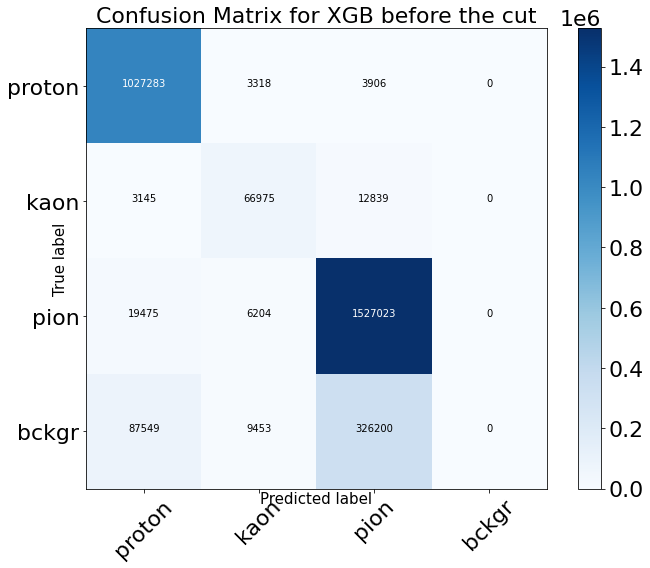

In [28]:
classes = ['proton', 'kaon', 'pion', 'bckgr']

np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(testParticles['Complex_pid'], testParticles['xgb_preds'])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
title = 'Confusion Matrix for XGB before the cut'
plot_confusion_matrix(cnf_matrix, classes=classes, title=title, normalize=False)
# fig.savefig(directory+'img/' + title + '.pdf')
plt.show()

Normalized confusion matrix
[[0.99 0.   0.   0.  ]
 [0.04 0.81 0.15 0.  ]
 [0.01 0.   0.98 0.  ]
 [0.21 0.02 0.77 0.  ]]


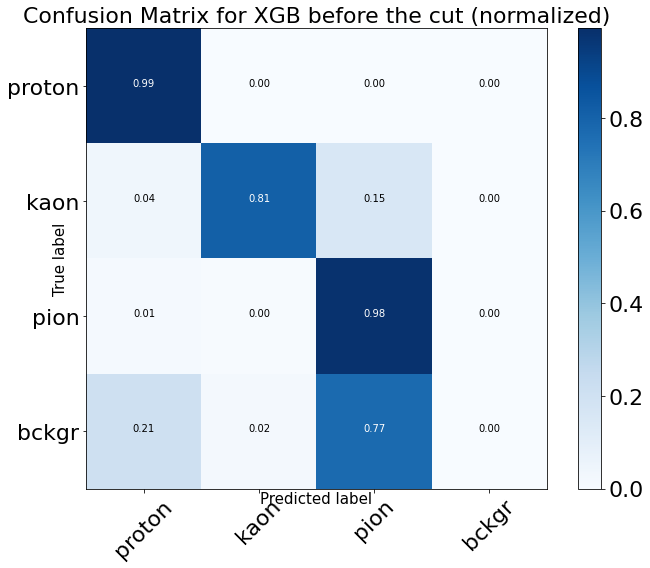

In [29]:
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(testParticles['Complex_pid'], testParticles['xgb_preds'])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
title = 'Confusion Matrix for XGB before the cut (normalized)'
plot_confusion_matrix(cnf_matrix, classes=classes, title=title, normalize=True)
# fig.savefig(directory+'img/' + title + '.pdf')
# fig.savefig(directory+'img/xgb_12agev/chi2geo/confusion_matrix_extreme_gradient_boosting_whole_data.png')
plt.show()

In [30]:
def plot_mass2(pid, name, range1, setLog=False):

    # fig, axs = plt.subplots(2, 1,figsize=(15,10), sharex=True,  gridspec_kw={'width_ratios': [10],
    #                            'height_ratios': [8,4]})
    fig, axs = plt.subplots(figsize=(15,10))

    
    xgb_mass = testParticles[testParticles['xgb_preds']==pid]['Complex_mass2']
    sim_mass = testParticles[testParticles['Complex_pid']==pid]['Complex_mass2']
    
    ns, bins, patches=axs.hist(xgb_mass ,bins = 300,  facecolor='red',alpha = 0.3, range=range1)
    ns1, bins1, patches1=axs.hist( sim_mass ,bins = 300,facecolor='blue',alpha = 0.3, range=range1)
    #plt.xlabel("Mass in GeV", fontsize = 15)
    axs.set_ylabel("counts", fontsize = 15)
    #axs[0].grid()
    axs.legend(('XGBoost selected ' + name,'all simulated ' + name), fontsize = 15, loc='upper right')

    #plt.rcParams["legend.loc"] = 'upper right'
    title = name +  " mass-squared histogram"
    yName = r'Counts'
    xName = r'$m^2$ $(GeV/c^2)^2$'
    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    axs.set_title(title, fontsize = 20)
    axs.grid()
    axs.tick_params(axis='both', which='major', labelsize=18)
    #fig.savefig("whole_sample_invmass_with_ML.png")
   

    # hist1, bin_edges1 = np.histogram(xgb_mass, bins=200, range=range1)
#     hist2, bin_edges2 = np.histogram(sim_mass, bins=200, range=range1)
        # axs.set_yscale('log')
    # fig.tight_layout()
    # plt.savefig(directory+'img/ml/ ' + name + '.pdf')
    plt.show()

    # fig.savefig(directory+'img/' + title + '.pdf')
  

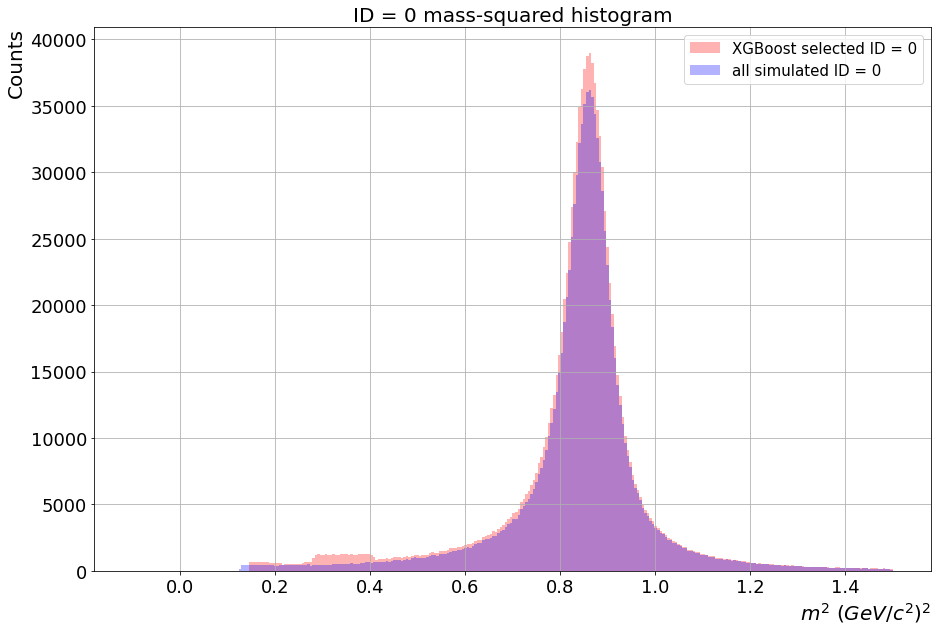

In [31]:
plot_mass2(0, 'ID = 0', (-.1, 1.5))

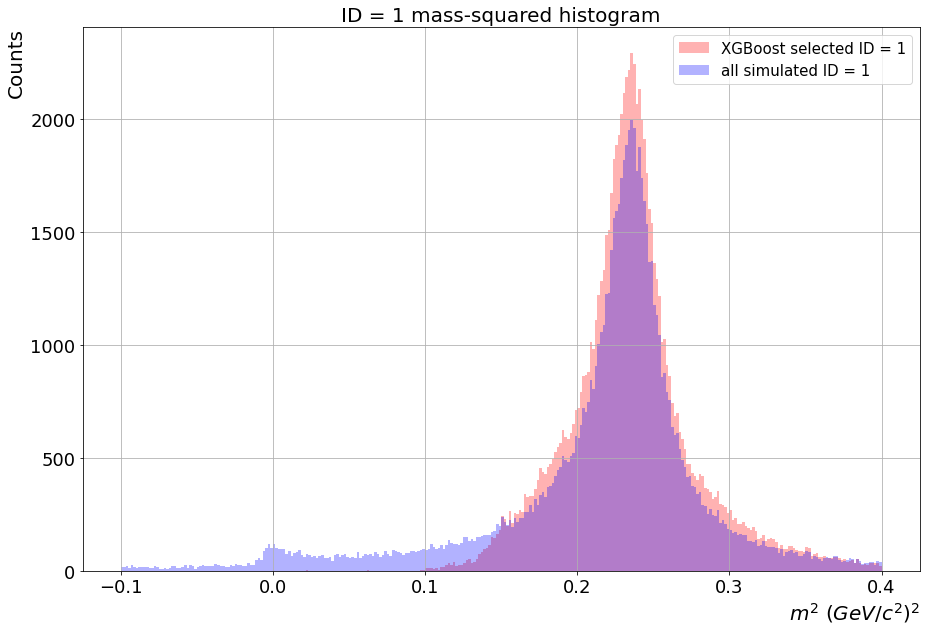

In [32]:
plot_mass2(1, 'ID = 1', (-.1, .4))

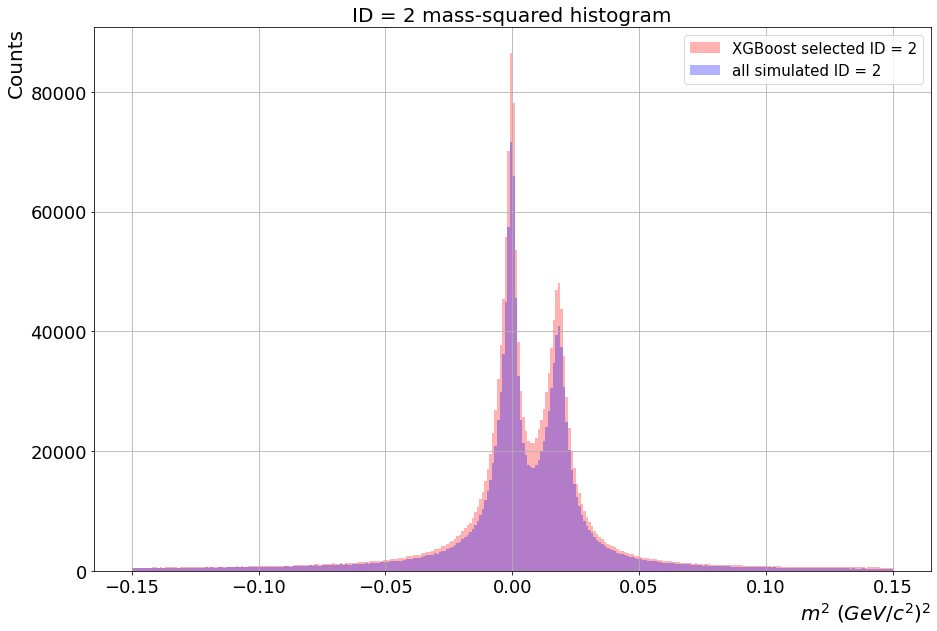

In [33]:
plot_mass2(2, 'ID = 2', (-.15, .15))

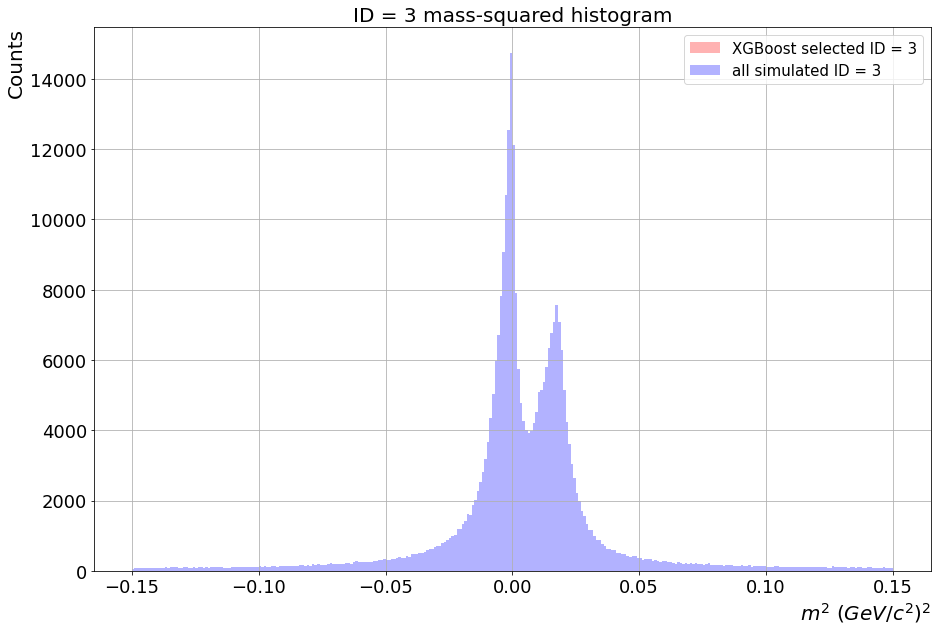

In [34]:
plot_mass2(3, 'ID = 3', (-.15, .15))

In [35]:
import matplotlib as mpl
def xgb_tof(pid):

    qp = testParticles[testParticles['xgb_preds']==pid]['Complex_q']*testParticles[testParticles['xgb_preds']==pid]['Complex_p']
    var_xaxis = qp
    mass2 = testParticles[testParticles['xgb_preds']==pid]['Complex_mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c^2)^2$'
    ranges = [[-10, 10],[-1, 2]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200, norm=mpl.colors.LogNorm(), range=ranges)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for XGB-selected particle ID = ' + str(pid)
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    # plt.savefig(directory+'img/ml/xgb ' + str(pid) + '.pdf')
    plt.show()
def sim_tof(pid):

    qp = testParticles[testParticles['Complex_pid']==pid]['Complex_q']*testParticles[testParticles['Complex_pid']==pid]['Complex_p']
    var_xaxis = qp
    mass2 = testParticles[testParticles['Complex_pid']==pid]['Complex_mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c^2)^2$'
    ranges = [[-10, 10],[-1, 2]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200, norm=mpl.colors.LogNorm(), range=ranges)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for all simulated particle ID = ' + str(pid)
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    # plt.savefig(directory+'img/ml/sim ' + str(pid) + '.pdf')
    plt.show()
    

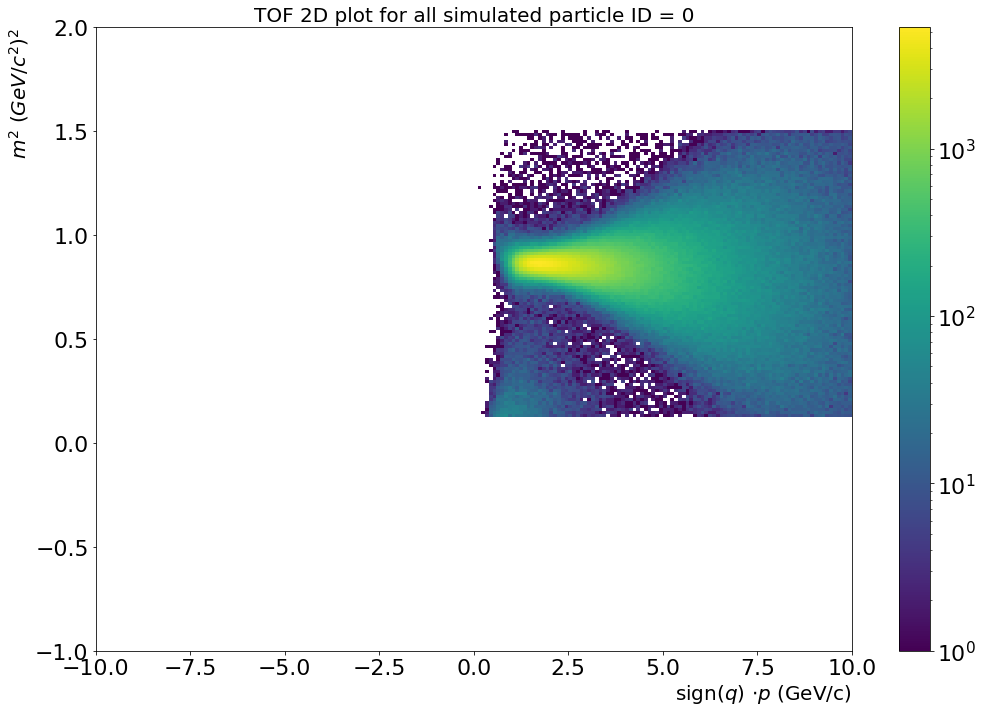

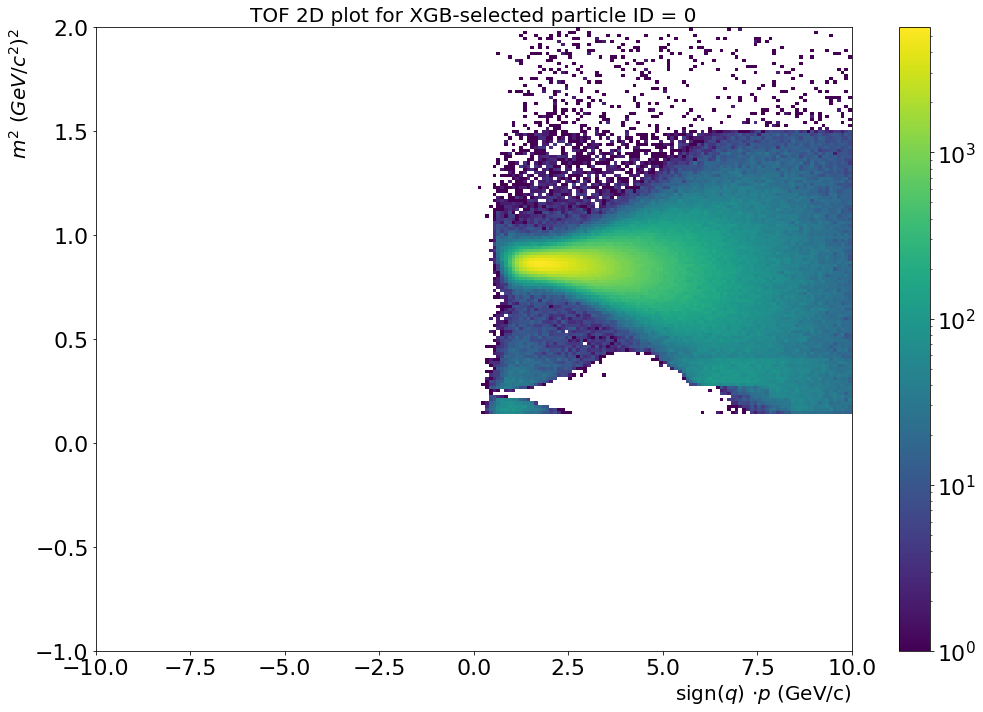

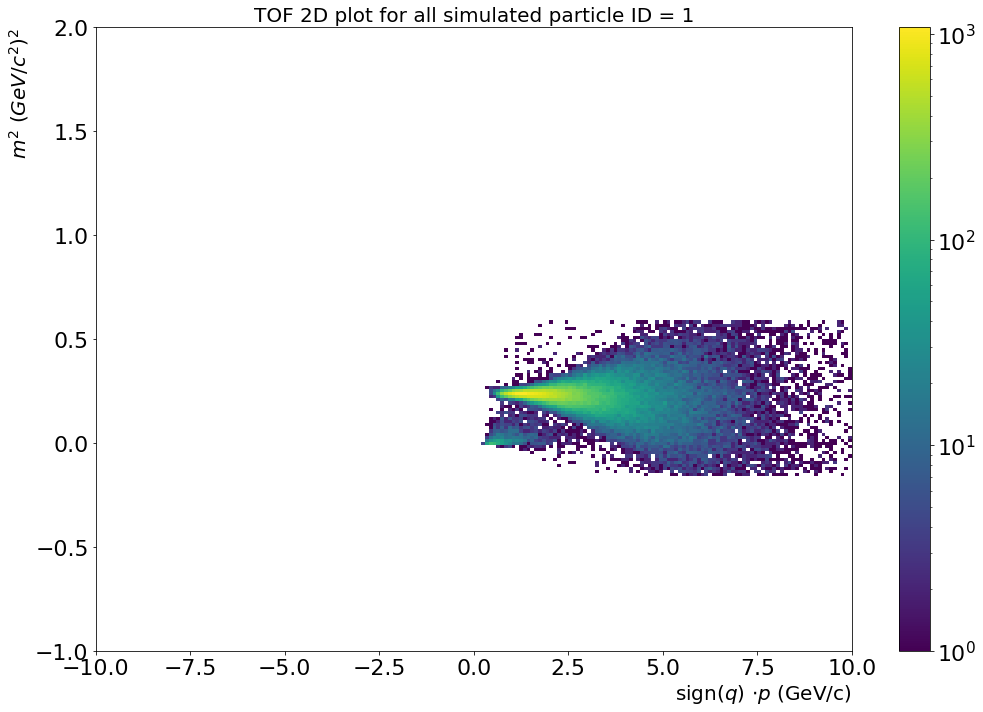

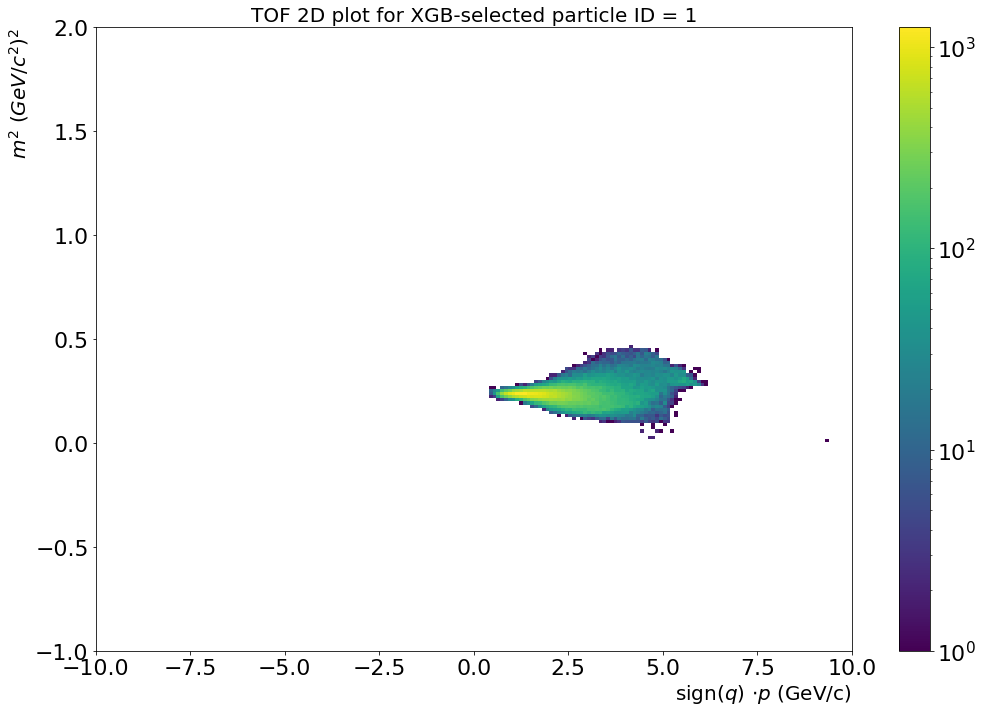

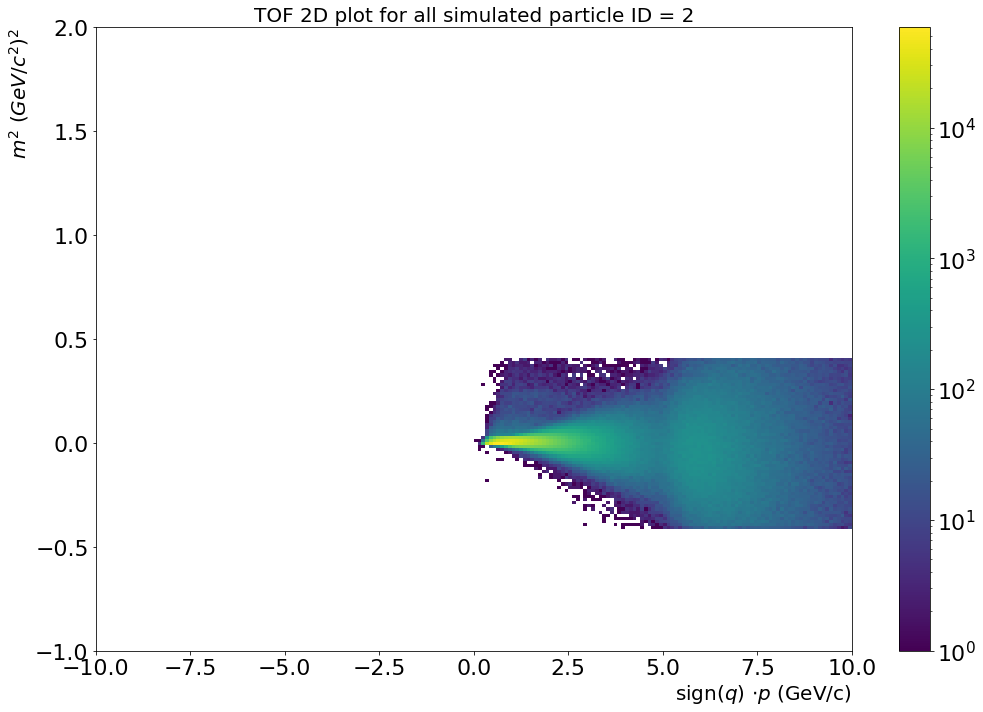

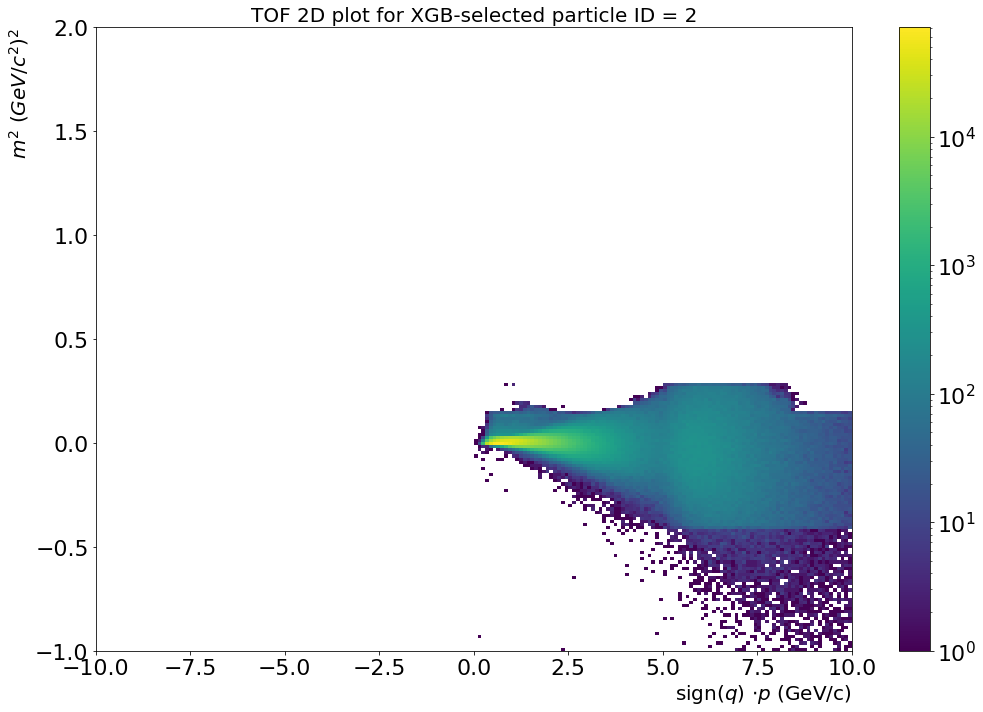

In [36]:
for i in range(3):
    sim_tof(i)
    xgb_tof(i)

In [104]:
def plot_eff2D(df, pid: int):

        dfTrue = df[(df['Complex_pid'] == pid)] #simulated
        dfReco = df[(df['xgb_preds'] == pid)] #reconstructed by xgboost

        x = np.array(dfTrue['Complex_rapidity'])
        y = np.array(dfTrue['Complex_pT'])

        xe = np.array(dfReco['Complex_rapidity'])
        ye = np.array(dfReco['Complex_pT'])

        fig = plt.figure(figsize=(8, 10))
        plt.title('$p_T$-rapidity efficiency for all selected for pid = {pid}'.format(pid=pid), fontsize=16)
        
        ranges = [[0, 5],[0, 3]]

        true, yedges, xedges = np.histogram2d(x, y, bins=50, range=ranges)
        reco, _, _ = np.histogram2d(xe, ye, bins=(yedges, xedges), range=ranges)

        eff = np.divide(true, reco, out=np.zeros_like(true), where=reco!=0)  #Efficiency
        eff[eff == 0] = np.nan #show zeros as white
        img = plt.imshow(eff, interpolation='nearest', origin='lower', vmin=0, vmax=1, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    
        cbar = fig.colorbar(img, fraction=0.025, pad=0.08) # above plot H
        cbar.set_label('efficiency (selected/simulated)', rotation=270, labelpad=20)
        
        plt.xlabel('rapidity', fontsize=18)
        plt.ylabel('$p_T$ (GeV/c)', fontsize=18)

        plt.tight_layout()

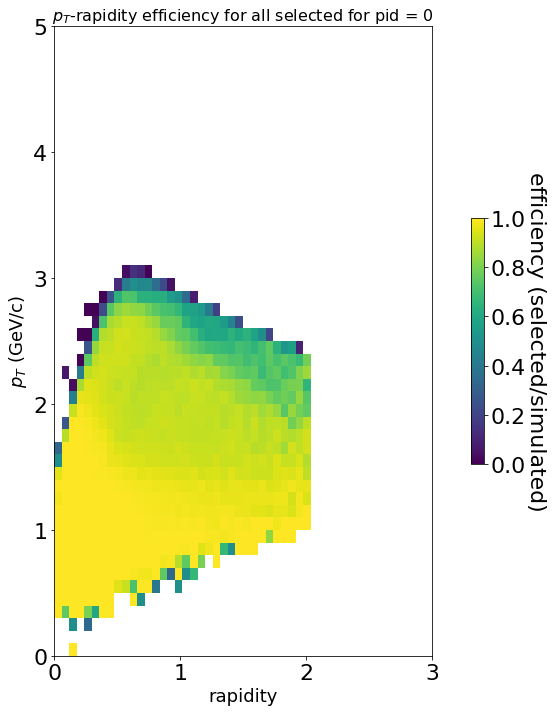

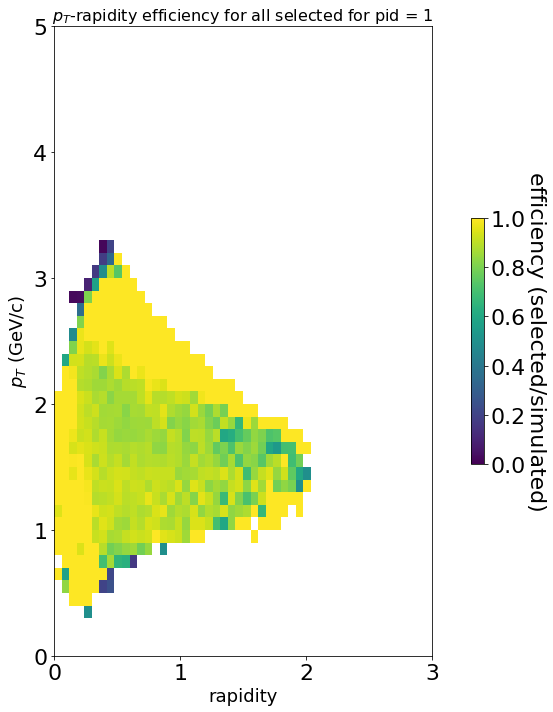

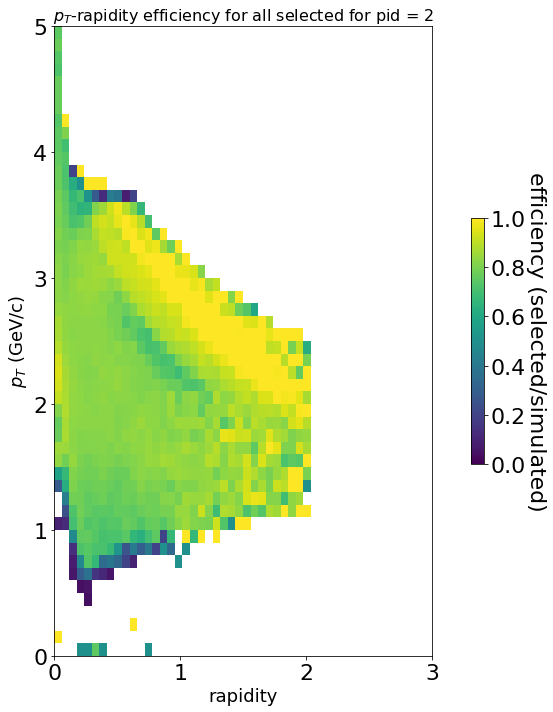

In [105]:
for i in range(3):
    plot_eff2D(testParticles, i)

In [102]:
def plot_pt_rapidity(df, pid: int):

        dfTrue = df[(df['Complex_pid'] == pid)] #simulated

        x = np.array(dfTrue['Complex_rapidity'])
        y = np.array(dfTrue['Complex_pT'])

        fig = plt.figure(figsize=(8, 10))
        plt.title('$p_T$-rapidity graph for all simulated pid = {pid}'.format(pid=pid), fontsize=16)
        
        ranges = [[0, 5],[0, 3]]

        true, yedges, xedges = np.histogram2d(x, y, bins=50, range=ranges)
        true[true == 0] = np.nan #show zeros as white

        
        img = plt.imshow(true, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    
        cbar = fig.colorbar(img, fraction=0.025, pad=0.08) # above plot H
        cbar.set_label('efficiency (selected/simulated)', rotation=270, labelpad=20)
        
        plt.xlabel('rapidity', fontsize=18)
        plt.ylabel('$p_T$ (GeV/c)', fontsize=18)

        plt.tight_layout()

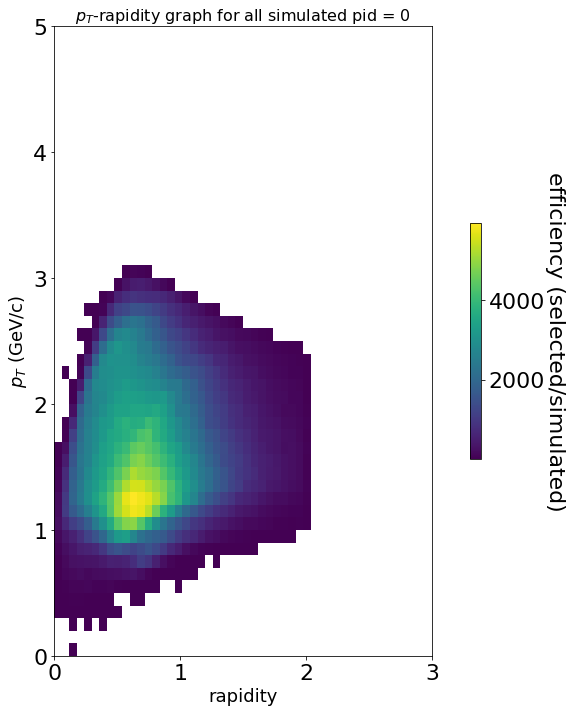

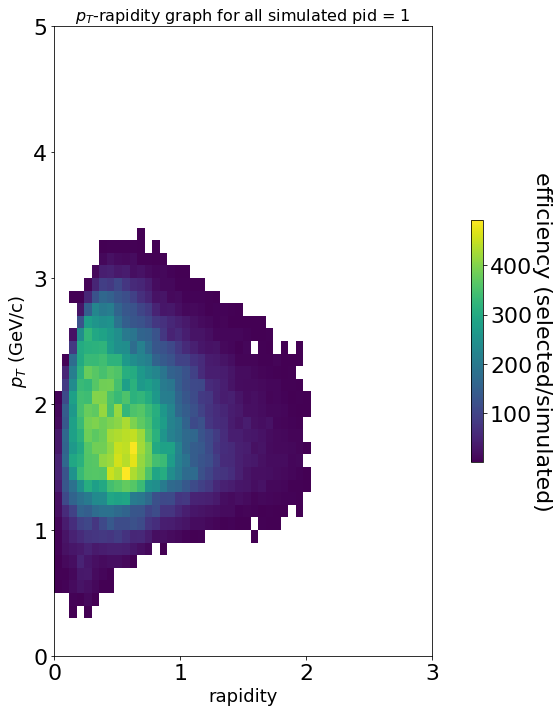

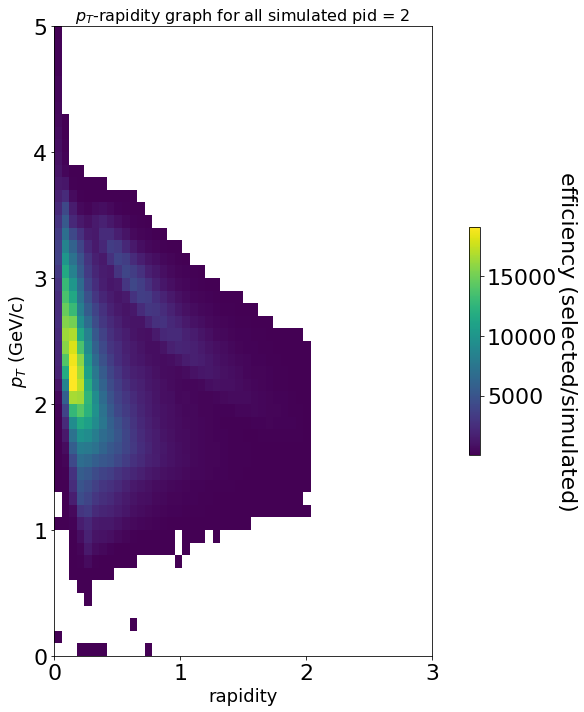

In [103]:
for i in range(3):
    plot_pt_rapidity(testParticles, i)

In [66]:
# #shapely based plots
# import shap
# # list1= ['$\chi^{2}_{geo}$','$\chi^{2}_{prim\ \pi^{-}}$','$\chi^{2}_{prim\ p^{+}}$','DCA','$L/\Delta L$','$mass_{\pi^-}^{2}$','$mass_{p^{+}}^{2}$']
# x_train_small = testParticles[features_for_train][2:10000]
# y_train_small = testParticles['Complex_pid'][2:10000]
# dtrain_shap = xgb.DMatrix(x_train_small, label = y_train_small)
# explainer = shap.TreeExplainer(model_hdl.get_original_model())
# shap_values = explainer.shap_values(dtrain_shap,check_additivity=False)
# fig, ax= plt.subplots(figsize=(8,6))
# shap.summary_plot(shap_values, x_train_small,list1, plot_size=[10,15], show=False)
# w, h = plt.gcf().get_size_inches()
# plt.gcf().set_size_inches(h+2, h)
# plt.gcf().set_size_inches(w, w*3/4)
# plt.gcf().axes[-1].set_aspect('auto')
# plt.gcf().axes[-1].set_box_aspect(50)
# plt.xlabel("SHAP value for $\Lambda$",fontsize=18)
# ax.spines['top'].set_visible(True)
# ax.spines['right'].set_visible(True)
# ax.spines['bottom'].set_visible(True)
# ax.spines['left'].set_visible(True)
# ax.tick_params(axis='both', which='major',length=10,direction='in', labelsize=15, zorder=4)
# ax.minorticks_on()
# ax.tick_params(axis='both', which='minor',length=5,direction='in', labelsize=15, zorder=5)
# fig.tight_layout()

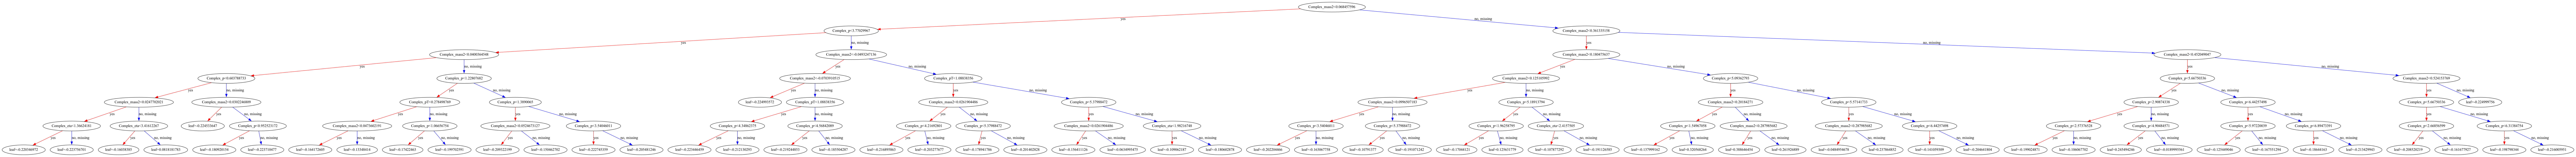

In [55]:
# #plot tree
# plt.rcParams["figure.figsize"] = (300, 100)

# from xgboost import plot_tree
# plot_tree(model_hdl.get_original_model(), num_trees=1)

# plt.savefig("tree1.png")

In [43]:
#lets save model
model_hdl.dump_model_handler("testmodel1")